In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 1
patience_student = 5
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 76
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_student = [5,3,10,0.5,0]
lmda_list_teacher = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [20]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [21]:
# Function to train the teacher model


def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        if lmda != 0:
        # Train the adversary at the start of each epoch
            train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epoch}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|███████████████████████████████████████████| 46/46 [00:18<00:00,  2.46it/s]


*****Epoch 1/100*****
*****Train Loss:  0.026808 Val Loss:  2.615523*****
*****Validation Accuracy: 61.59%*****
*****Total Avg Disparity: 0.13990770830720164*****

Class Team_Sports: Recall Difference = 0.06151690313540026
Class Celebration: Recall Difference = -0.06744186046511624
Class Parade: Recall Difference = 0.0941825005864414
Class Waiter_Or_Waitress: Recall Difference = -0.1886524822695036
Class Individual_Sports: Recall Difference = -0.12867453574919185
Class Surgeons: Recall Difference = 0.05567765567765559
Class Spa: Recall Difference = -0.19858156028368795
Class Law_Enforcement: Recall Difference = 0.20114942528735635
Class Business: Recall Difference = -0.08034953111679455
Class Dresses: Recall Difference = -0.7559523809523809
Class Water Activities: Recall Difference = 0.11448140900195691
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.03535882661079093
Class Cheering: Recall Difference = 0.004296235679214444
Class Performance_A

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 2/100*****
*****Train Loss:  0.019256 Val Loss:  2.489779*****
*****Validation Accuracy: 61.62%*****
*****Total Avg Disparity: 0.14731622390948404*****

Class Team_Sports: Recall Difference = 0.0011327144275123935
Class Celebration: Recall Difference = -0.04883720930232571
Class Parade: Recall Difference = 0.07694112127609665
Class Waiter_Or_Waitress: Recall Difference = -0.13120567375886538
Class Individual_Sports: Recall Difference = -0.1144650778136983
Class Surgeons: Recall Difference = 0.09010989010989012
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.23563218390804597
Class Business: Recall Difference = -0.051150895140664954
Class Dresses: Recall Difference = -0.7559523809523809
Class Water Activities: Recall Difference = 0.0639269406392694
Class Picnic: Recall Difference = -0.03703703703703709
Class Rescue: Recall Difference = 0.06652697747511782
Class Cheering: Recall Difference = 0.1059738134206219
Class Performance_

100%|███████████████████████████████████████████| 46/46 [00:18<00:00,  2.46it/s]


*****Epoch 3/100*****
*****Train Loss:  0.019762 Val Loss:  2.503368*****
*****Validation Accuracy: 61.79%*****
*****Total Avg Disparity: 0.13028042538147663*****

Class Team_Sports: Recall Difference = 0.06959771121620828
Class Celebration: Recall Difference = -0.04186046511627911
Class Parade: Recall Difference = 0.11013370865587624
Class Waiter_Or_Waitress: Recall Difference = -0.021985815602836745
Class Individual_Sports: Recall Difference = -0.12863694459063224
Class Surgeons: Recall Difference = 0.11575091575091573
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.1568486590038316
Class Business: Recall Difference = -0.026214833759590828
Class Dresses: Recall Difference = -0.6845238095238095
Class Water Activities: Recall Difference = 0.12165688193085467
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.0885280251440545
Class Cheering: Recall Difference = 0.013911620294599025
Class Performance

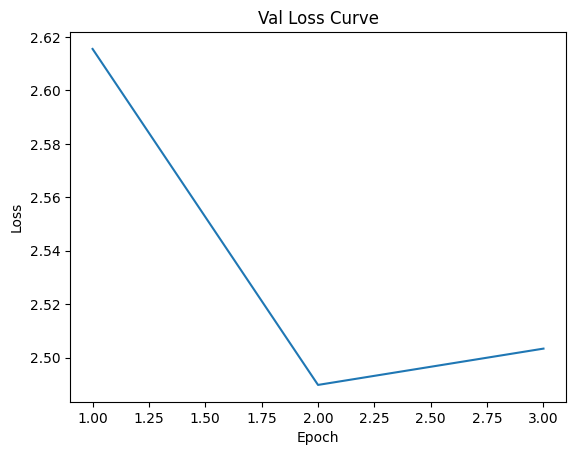

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [22]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    # teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # # Replace the last fully connected layer with a new one
    # teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.3681857542080038


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.8469439543345395


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.5747709993053886


100%|█████████████████████████████████████████| 136/136 [01:43<00:00,  1.31it/s]


Average Pretrain Adversary epoch loss:  0.4808885457322878


100%|█████████████████████████████████████████| 136/136 [01:43<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.4808768275029519


100%|█████████████████████████████████████████| 136/136 [01:43<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.4807978548547801


100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.4297708299230127


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 1/100*****
*****Train Loss:  0.423079 Val Loss:  2.572659*****
*****Validation Accuracy: 60.75%*****
*****Total Avg Disparity: 0.15246738928803663*****

Class Team_Sports: Recall Difference = 0.02223389969054712
Class Celebration: Recall Difference = 0.03720930232558145
Class Parade: Recall Difference = 0.034248182031433205
Class Waiter_Or_Waitress: Recall Difference = -0.23404255319148926
Class Individual_Sports: Recall Difference = -0.1465303360649577
Class Surgeons: Recall Difference = 0.038827838827838856
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.10105363984674309
Class Business: Recall Difference = 0.05136402387041772
Class Dresses: Recall Difference = -0.6547619047619047
Class Water Activities: Recall Difference = 0.18721461187214616
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.1699842849659507
Class Cheering: Recall Difference = -0.006955810147299568
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.380173414507333


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 2/100*****
*****Train Loss: -0.498943 Val Loss:  2.657269*****
*****Validation Accuracy: 62.45%*****
*****Total Avg Disparity: 0.12069123966070604*****

Class Team_Sports: Recall Difference = 0.018975886027909117
Class Celebration: Recall Difference = -0.05813953488372098
Class Parade: Recall Difference = 0.0711939948393151
Class Waiter_Or_Waitress: Recall Difference = -0.22056737588652475
Class Individual_Sports: Recall Difference = -0.13247124276370192
Class Surgeons: Recall Difference = -0.10402930402930399
Class Spa: Recall Difference = 0.028368794326241065
Class Law_Enforcement: Recall Difference = 0.15301724137931028
Class Business: Recall Difference = 0.1261722080136402
Class Dresses: Recall Difference = -0.5202380952380952
Class Water Activities: Recall Difference = 0.12241791693846482
Class Picnic: Recall Difference = -0.05555555555555558
Class Rescue: Recall Difference = 0.011262441068622286
Class Cheering: Recall Difference = -0.027618657937806934
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.37154275562395067


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 3/100*****
*****Train Loss: -1.019141 Val Loss:  3.382194*****
*****Validation Accuracy: 63.03%*****
*****Total Avg Disparity: 0.11411234703746623*****

Class Team_Sports: Recall Difference = 0.026274303730951187
Class Celebration: Recall Difference = -0.013953488372093092
Class Parade: Recall Difference = 0.059699741965751674
Class Waiter_Or_Waitress: Recall Difference = -0.2673758865248226
Class Individual_Sports: Recall Difference = -0.1359672205097362
Class Surgeons: Recall Difference = -0.07545787545787541
Class Spa: Recall Difference = 0.13475177304964536
Class Law_Enforcement: Recall Difference = 0.08764367816091967
Class Business: Recall Difference = 0.04688832054560954
Class Dresses: Recall Difference = -0.6547619047619048
Class Water Activities: Recall Difference = 0.07262448358338769
Class Picnic: Recall Difference = -0.03703703703703709
Class Rescue: Recall Difference = -0.0036668412781560855
Class Cheering: Recall Difference = -0.007978723404255372
Class Perform

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.3707573917858741


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 4/100*****
*****Train Loss: -1.218129 Val Loss:  2.825983*****
*****Validation Accuracy: 64.68%*****
*****Total Avg Disparity: 0.15464318601333377*****

Class Team_Sports: Recall Difference = 0.0037134349273078016
Class Celebration: Recall Difference = -0.018604651162790642
Class Parade: Recall Difference = 0.07307060755336614
Class Waiter_Or_Waitress: Recall Difference = -0.19929078014184387
Class Individual_Sports: Recall Difference = -0.13213292233666651
Class Surgeons: Recall Difference = -0.13260073260073257
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.11877394636015315
Class Business: Recall Difference = 0.03942881500426254
Class Dresses: Recall Difference = -0.6785714285714285
Class Water Activities: Recall Difference = 0.06327462491846059
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.12912519643792558
Class Cheering: Recall Difference = 0.04521276595744678
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.33136122695663395


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 5/100*****
*****Train Loss: -0.723051 Val Loss:  2.436831*****
*****Validation Accuracy: 63.55%*****
*****Total Avg Disparity: 0.13696790930660793*****

Class Team_Sports: Recall Difference = 0.02341332399135876
Class Celebration: Recall Difference = 0.0790697674418605
Class Parade: Recall Difference = 0.043162092423176146
Class Waiter_Or_Waitress: Recall Difference = -0.27234042553191495
Class Individual_Sports: Recall Difference = -0.12859935343207285
Class Surgeons: Recall Difference = -0.12380952380952387
Class Spa: Recall Difference = -0.16312056737588665
Class Law_Enforcement: Recall Difference = 0.018438697318007624
Class Business: Recall Difference = 0.04241261722080131
Class Dresses: Recall Difference = -0.7261904761904763
Class Water Activities: Recall Difference = 0.11665579473798637
Class Picnic: Recall Difference = -1.1102230246251565e-16
Class Rescue: Recall Difference = 0.0785751702462022
Class Cheering: Recall Difference = -0.0591243862520458
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.2620132528245449


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 6/100*****
*****Train Loss: -0.582282 Val Loss:  3.248653*****
*****Validation Accuracy: 63.61%*****
*****Total Avg Disparity: 0.127143543083767*****

Class Team_Sports: Recall Difference = -0.005546797454311747
Class Celebration: Recall Difference = -0.018604651162790642
Class Parade: Recall Difference = 0.07436077879427627
Class Waiter_Or_Waitress: Recall Difference = -0.24468085106382975
Class Individual_Sports: Recall Difference = -0.14987594917675373
Class Surgeons: Recall Difference = -0.024175824175824145
Class Spa: Recall Difference = -0.2624113475177306
Class Law_Enforcement: Recall Difference = 0.18031609195402298
Class Business: Recall Difference = -0.03580562659846531
Class Dresses: Recall Difference = -0.6369047619047619
Class Water Activities: Recall Difference = 0.07914764079147651
Class Picnic: Recall Difference = -0.07407407407407407
Class Rescue: Recall Difference = -0.06364588789942377
Class Cheering: Recall Difference = 0.08019639934533557
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.24683596763540716


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 7/100*****
*****Train Loss: -0.617307 Val Loss:  3.565824*****
*****Validation Accuracy: 63.49%*****
*****Total Avg Disparity: 0.1549612336444554*****

Class Team_Sports: Recall Difference = 0.027453728031762603
Class Celebration: Recall Difference = 0.0046511627906977715
Class Parade: Recall Difference = 0.11271405113769639
Class Waiter_Or_Waitress: Recall Difference = -0.22056737588652475
Class Individual_Sports: Recall Difference = -0.15701826930305995
Class Surgeons: Recall Difference = -0.07252747252747249
Class Spa: Recall Difference = -0.47517730496453897
Class Law_Enforcement: Recall Difference = 0.11470306513409956
Class Business: Recall Difference = 0.002344416027280416
Class Dresses: Recall Difference = -0.7261904761904762
Class Water Activities: Recall Difference = 0.12383126766688402
Class Picnic: Recall Difference = -0.0185185185185186
Class Rescue: Recall Difference = 0.08826610790990047
Class Cheering: Recall Difference = -0.044394435351882144
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.24038134011275628


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 8/100*****
*****Train Loss: -0.578336 Val Loss:  4.015459*****
*****Validation Accuracy: 63.92%*****
*****Total Avg Disparity: 0.14350752650824836*****

Class Team_Sports: Recall Difference = -0.013347346295323081
Class Celebration: Recall Difference = -0.006976744186046546
Class Parade: Recall Difference = 0.08972554539056998
Class Waiter_Or_Waitress: Recall Difference = -0.23120567375886525
Class Individual_Sports: Recall Difference = -0.18897075407864072
Class Surgeons: Recall Difference = -0.07252747252747255
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.14583333333333337
Class Business: Recall Difference = -0.026001705029837896
Class Dresses: Recall Difference = -0.49047619047619045
Class Water Activities: Recall Difference = 0.08490976299195463
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.11000523834468307
Class Cheering: Recall Difference = 0.030482815057283175
Class Perfo

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.2318610207122915


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 9/100*****
*****Train Loss: -0.597932 Val Loss:  3.873775*****
*****Validation Accuracy: 64.24%*****
*****Total Avg Disparity: 0.15192842391296696*****

Class Team_Sports: Recall Difference = 0.02195364045075021
Class Celebration: Recall Difference = -0.027906976744186074
Class Parade: Recall Difference = 0.07248416608022512
Class Waiter_Or_Waitress: Recall Difference = -0.14184397163120566
Class Individual_Sports: Recall Difference = -0.20302984737989638
Class Surgeons: Recall Difference = -0.10109890109890107
Class Spa: Recall Difference = -0.16312056737588665
Class Law_Enforcement: Recall Difference = 0.1872605363984674
Class Business: Recall Difference = -0.026001705029838118
Class Dresses: Recall Difference = -0.8154761904761905
Class Water Activities: Recall Difference = 0.10219612959338975
Class Picnic: Recall Difference = -0.20370370370370366
Class Rescue: Recall Difference = 0.11000523834468301
Class Cheering: Recall Difference = -0.002454991816693952
Class Performa

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.31it/s]


Average Adversary epoch loss: 0.22083658166229725


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 10/100*****
*****Train Loss: -0.585128 Val Loss:  4.101579*****
*****Validation Accuracy: 64.10%*****
*****Total Avg Disparity: 0.12548220837641982*****

Class Team_Sports: Recall Difference = 0.048554913294797775
Class Celebration: Recall Difference = -0.023255813953488302
Class Parade: Recall Difference = 0.05852685901946986
Class Waiter_Or_Waitress: Recall Difference = -0.0886524822695034
Class Individual_Sports: Recall Difference = -0.15675513119314344
Class Surgeons: Recall Difference = -0.021245421245421336
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.19133141762452088
Class Business: Recall Difference = 0.039215686274509776
Class Dresses: Recall Difference = -0.7321428571428572
Class Water Activities: Recall Difference = 0.06468797564687978
Class Picnic: Recall Difference = -0.03703703703703709
Class Rescue: Recall Difference = 0.11707700366684132
Class Cheering: Recall Difference = 0.046235679214402636
Class Perform

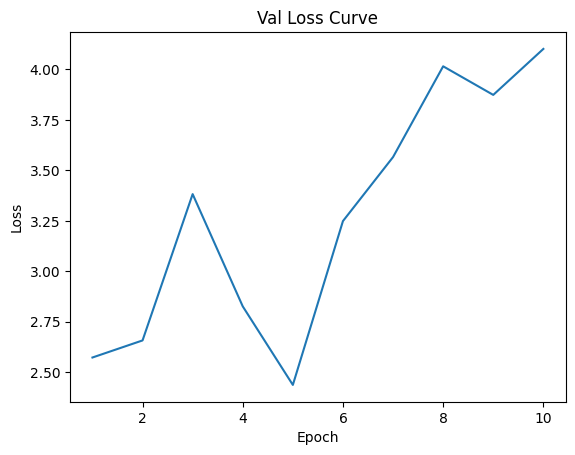

Student weights and architecture saved and exported for lambda: 5


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.3657808860435205


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.8509775132817381


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.5793671507169219


100%|█████████████████████████████████████████| 136/136 [01:43<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.4212553983225542


100%|█████████████████████████████████████████| 136/136 [01:43<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.4211034152437659


100%|█████████████████████████████████████████| 136/136 [01:43<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.4212326569592251


100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.3748124420423718


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 1/100*****
*****Train Loss:  1.492909 Val Loss:  4.509324*****
*****Validation Accuracy: 60.26%*****
*****Total Avg Disparity: 0.1162980920116349*****

Class Team_Sports: Recall Difference = -0.023950487534302733
Class Celebration: Recall Difference = -0.05581395348837209
Class Parade: Recall Difference = 0.05148956134177807
Class Waiter_Or_Waitress: Recall Difference = -0.12907801418439724
Class Individual_Sports: Recall Difference = -0.11472821592361482
Class Surgeons: Recall Difference = 0.0073260073260073
Class Spa: Recall Difference = -0.19858156028368784
Class Law_Enforcement: Recall Difference = 0.09650383141762459
Class Business: Recall Difference = -0.03900255754475701
Class Dresses: Recall Difference = -0.6130952380952381
Class Water Activities: Recall Difference = 0.10578386605783874
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.12912519643792558
Class Cheering: Recall Difference = 0.019844517184942734
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.33816353023490486


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 2/100*****
*****Train Loss:  0.537210 Val Loss:  2.769731*****
*****Validation Accuracy: 63.49%*****
*****Total Avg Disparity: 0.14548414609789043*****

Class Team_Sports: Recall Difference = 0.09007999065802552
Class Celebration: Recall Difference = 0.020930232558139583
Class Parade: Recall Difference = 0.03870513722730462
Class Waiter_Or_Waitress: Recall Difference = -0.20992907801418415
Class Individual_Sports: Recall Difference = -0.2313359897752051
Class Surgeons: Recall Difference = 0.03003663003663004
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.03975095785440608
Class Business: Recall Difference = 0.0002131287297527651
Class Dresses: Recall Difference = -0.6726190476190476
Class Water Activities: Recall Difference = 0.13035442487497273
Class Picnic: Recall Difference = -0.16666666666666669
Class Rescue: Recall Difference = 0.11000523834468307
Class Cheering: Recall Difference = -0.07937806873977082
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.3449660700691097


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 3/100*****
*****Train Loss: -0.120005 Val Loss:  3.294745*****
*****Validation Accuracy: 64.04%*****
*****Total Avg Disparity: 0.12296703548299753*****

Class Team_Sports: Recall Difference = 0.0690371927366149
Class Celebration: Recall Difference = -0.07441860465116279
Class Parade: Recall Difference = 0.048909218859957804
Class Waiter_Or_Waitress: Recall Difference = -0.08581560283687939
Class Individual_Sports: Recall Difference = -0.1428088113675665
Class Surgeons: Recall Difference = 0.0241758241758242
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.05244252873563193
Class Business: Recall Difference = 0.011082693947144007
Class Dresses: Recall Difference = -0.555952380952381
Class Water Activities: Recall Difference = 0.13318112633181123
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.13174436877946566
Class Cheering: Recall Difference = -0.0889934533551554
Class Performance_And_E

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.339280575294705


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 4/100*****
*****Train Loss: -0.357036 Val Loss:  3.080241*****
*****Validation Accuracy: 65.05%*****
*****Total Avg Disparity: 0.1333612893900264*****

Class Team_Sports: Recall Difference = 0.04647632393297141
Class Celebration: Recall Difference = -0.013953488372092981
Class Parade: Recall Difference = 0.07823129251700667
Class Waiter_Or_Waitress: Recall Difference = -0.11276595744680862
Class Individual_Sports: Recall Difference = -0.17107736260431539
Class Surgeons: Recall Difference = -0.03003663003663004
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.09075670498084287
Class Business: Recall Difference = -0.10315430520034097
Class Dresses: Recall Difference = -0.7321428571428572
Class Water Activities: Recall Difference = 0.10219612959338986
Class Picnic: Recall Difference = -0.05555555555555558
Class Rescue: Recall Difference = 0.19905709795704557
Class Cheering: Recall Difference = -0.10065466448445165
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.3315552948590587


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 5/100*****
*****Train Loss: -0.493837 Val Loss:  3.484866*****
*****Validation Accuracy: 65.22%*****
*****Total Avg Disparity: 0.11540655221240656*****

Class Team_Sports: Recall Difference = 0.032895428271150884
Class Celebration: Recall Difference = -0.0023255813953486637
Class Parade: Recall Difference = 0.11142387989678626
Class Waiter_Or_Waitress: Recall Difference = -0.13404255319148917
Class Individual_Sports: Recall Difference = -0.11435230433801968
Class Surgeons: Recall Difference = 0.027106227106227065
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.1357758620689653
Class Business: Recall Difference = -0.02493606138107418
Class Dresses: Recall Difference = -0.538095238095238
Class Water Activities: Recall Difference = 0.15775168514894544
Class Picnic: Recall Difference = -0.05555555555555558
Class Rescue: Recall Difference = 0.21843897328444217
Class Cheering: Recall Difference = -0.0008183306055646877
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.31497945647467585


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 6/100*****
*****Train Loss: -0.500920 Val Loss:  3.054594*****
*****Validation Accuracy: 64.96%*****
*****Total Avg Disparity: 0.16993543114268916*****

Class Team_Sports: Recall Difference = 0.04473638115256651
Class Celebration: Recall Difference = -0.032558139534883734
Class Parade: Recall Difference = 0.09359605911330049
Class Waiter_Or_Waitress: Recall Difference = -0.2326241134751773
Class Individual_Sports: Recall Difference = -0.12145703330576663
Class Surgeons: Recall Difference = -0.03296703296703296
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.13553639846743293
Class Business: Recall Difference = 0.013213981244671769
Class Dresses: Recall Difference = -0.7321428571428571
Class Water Activities: Recall Difference = 0.16133942161339432
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.19669984284965947
Class Cheering: Recall Difference = -0.07119476268412445
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.27558905872351985


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 7/100*****
*****Train Loss: -0.044108 Val Loss:  4.539634*****
*****Validation Accuracy: 63.69%*****
*****Total Avg Disparity: 0.1464862137095571*****

Class Team_Sports: Recall Difference = 0.07021661703742621
Class Celebration: Recall Difference = -0.041860465116279055
Class Parade: Recall Difference = 0.07752756274923767
Class Waiter_Or_Waitress: Recall Difference = -0.24184397163120563
Class Individual_Sports: Recall Difference = -0.1712277272385535
Class Surgeons: Recall Difference = -0.03003663003663004
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.08045977011494254
Class Business: Recall Difference = -0.06734867860187554
Class Dresses: Recall Difference = -0.7380952380952379
Class Water Activities: Recall Difference = 0.11230702326592734
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.13436354112100574
Class Cheering: Recall Difference = 0.0006137479541734603
Class Performance_And_Entertainment

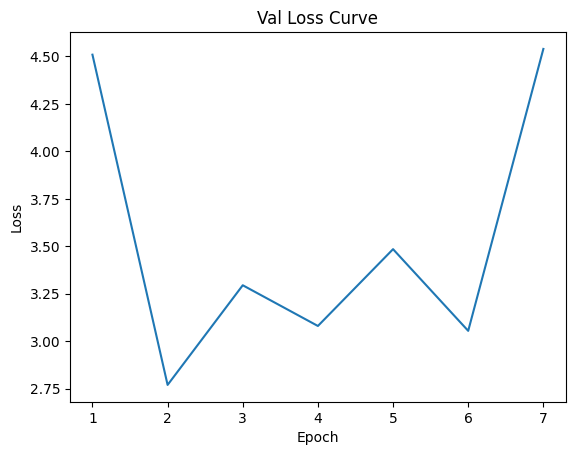

Student weights and architecture saved and exported for lambda: 3


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.3586485683918


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.8464105273870861


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.580304001841475


100%|█████████████████████████████████████████| 136/136 [01:41<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.4754543799687834


100%|█████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.4754363026689081


100%|█████████████████████████████████████████| 136/136 [01:41<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.4754757125149755


100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.36696670160574074


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 1/100*****
*****Train Loss: -0.091519 Val Loss:  1.145512*****
*****Validation Accuracy: 60.58%*****
*****Total Avg Disparity: 0.13413417014025597*****

Class Team_Sports: Recall Difference = 0.04429263735622124
Class Celebration: Recall Difference = -0.07209302325581396
Class Parade: Recall Difference = 0.21944639924935483
Class Waiter_Or_Waitress: Recall Difference = -0.19929078014184387
Class Individual_Sports: Recall Difference = -0.09683482444928959
Class Surgeons: Recall Difference = -0.03296703296703296
Class Spa: Recall Difference = 0.028368794326241176
Class Law_Enforcement: Recall Difference = 0.08022030651340994
Class Business: Recall Difference = 0.04028132992327366
Class Dresses: Recall Difference = -0.6607142857142857
Class Water Activities: Recall Difference = 0.09860839312894087
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.17731796752226298
Class Cheering: Recall Difference = -0.13461538461538464
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.2793692896033035


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 2/100*****
*****Train Loss: -1.078872 Val Loss:  1.029957*****
*****Validation Accuracy: 63.69%*****
*****Total Avg Disparity: 0.15222923239970707*****

Class Team_Sports: Recall Difference = 0.08435803117884066
Class Celebration: Recall Difference = 0.011627906976744262
Class Parade: Recall Difference = 0.08397841895378833
Class Waiter_Or_Waitress: Recall Difference = -0.2191489361702128
Class Individual_Sports: Recall Difference = -0.17821968273062183
Class Surgeons: Recall Difference = -0.02417582417582409
Class Spa: Recall Difference = -0.4539007092198583
Class Law_Enforcement: Recall Difference = 0.09458812260536398
Class Business: Recall Difference = -0.031543052003410066
Class Dresses: Recall Difference = -0.7142857142857143
Class Water Activities: Recall Difference = 0.09143292020004357
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.03535882661079098
Class Cheering: Recall Difference = -0.02270867430441903
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.32it/s]


Average Adversary epoch loss: 0.2678472737179083


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 3/100*****
*****Train Loss: -1.594940 Val Loss:  1.570928*****
*****Validation Accuracy: 63.92%*****
*****Total Avg Disparity: 0.1372595381961867*****

Class Team_Sports: Recall Difference = 0.035476148770946514
Class Celebration: Recall Difference = -0.05348837209302315
Class Parade: Recall Difference = 0.09230588787239036
Class Waiter_Or_Waitress: Recall Difference = -0.19929078014184398
Class Individual_Sports: Recall Difference = -0.1144274866551388
Class Surgeons: Recall Difference = 0.06739926739926738
Class Spa: Recall Difference = 0.17730496453900702
Class Law_Enforcement: Recall Difference = 0.14583333333333337
Class Business: Recall Difference = 0.03601875532821819
Class Dresses: Recall Difference = -0.7261904761904762
Class Water Activities: Recall Difference = 0.13394216133942172
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.07150340492404395
Class Cheering: Recall Difference = 0.005728314238952592
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.2554785458042341


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.30it/s]


*****Epoch 4/100*****
*****Train Loss: -1.635982 Val Loss:  1.560636*****
*****Validation Accuracy: 64.18%*****
*****Total Avg Disparity: 0.15659224441364522*****

Class Team_Sports: Recall Difference = 0.04277456647398836
Class Celebration: Recall Difference = 0.06279069767441858
Class Parade: Recall Difference = 0.05524278676988026
Class Waiter_Or_Waitress: Recall Difference = -0.2872340425531914
Class Individual_Sports: Recall Difference = -0.0859333884670328
Class Surgeons: Recall Difference = -0.018315018315018305
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.14966475095785436
Class Business: Recall Difference = -0.05434782608695654
Class Dresses: Recall Difference = -0.7202380952380953
Class Water Activities: Recall Difference = 0.13394216133942138
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.13174436877946566
Class Cheering: Recall Difference = -0.056055646481178445
Class Performance_And_Entertainmen

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.2489907094003523


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 5/100*****
*****Train Loss: -1.852895 Val Loss:  1.908546*****
*****Validation Accuracy: 64.13%*****
*****Total Avg Disparity: 0.12030998839671204*****

Class Team_Sports: Recall Difference = 0.042938051030536384
Class Celebration: Recall Difference = -0.025581395348837188
Class Parade: Recall Difference = 0.050199390100867936
Class Waiter_Or_Waitress: Recall Difference = -0.16312056737588643
Class Individual_Sports: Recall Difference = -0.19592511841214955
Class Surgeons: Recall Difference = 0.0644688644688644
Class Spa: Recall Difference = -0.03546099290780136
Class Law_Enforcement: Recall Difference = 0.15660919540229878
Class Business: Recall Difference = -0.031329923273657245
Class Dresses: Recall Difference = -0.744047619047619
Class Water Activities: Recall Difference = 0.08632311372037382
Class Picnic: Recall Difference = -0.05555555555555558
Class Rescue: Recall Difference = 0.04740701938187536
Class Cheering: Recall Difference = -0.05094108019639937
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.24482579485458486


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 6/100*****
*****Train Loss: -1.886255 Val Loss:  2.602567*****
*****Validation Accuracy: 64.85%*****
*****Total Avg Disparity: 0.14793759736675907*****

Class Team_Sports: Recall Difference = 0.04389560343317578
Class Celebration: Recall Difference = -0.06976744186046518
Class Parade: Recall Difference = 0.019469856908280514
Class Waiter_Or_Waitress: Recall Difference = -0.2737588652482269
Class Individual_Sports: Recall Difference = -0.10021802871964525
Class Surgeons: Recall Difference = 0.0388278388278388
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.1048850574712642
Class Business: Recall Difference = -0.010656436487638477
Class Dresses: Recall Difference = -0.75
Class Water Activities: Recall Difference = 0.14546640574037828
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.10529072812991097
Class Cheering: Recall Difference = -0.11988543371522087
Class Performance_And_Entertainm

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.2424610525588779


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 7/100*****
*****Train Loss: -1.968579 Val Loss:  1.527485*****
*****Validation Accuracy: 65.11%*****
*****Total Avg Disparity: 0.1666691974382803*****

Class Team_Sports: Recall Difference = 0.06319845857418105
Class Celebration: Recall Difference = -0.07674418604651162
Class Parade: Recall Difference = 0.07060755336617408
Class Waiter_Or_Waitress: Recall Difference = -0.16312056737588643
Class Individual_Sports: Recall Difference = -0.12506578452747918
Class Surgeons: Recall Difference = 0.09010989010989018
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.1566091954022989
Class Business: Recall Difference = -0.03559249786871266
Class Dresses: Recall Difference = -0.761904761904762
Class Water Activities: Recall Difference = 0.10002174385736029
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.06888423258250392
Class Cheering: Recall Difference = -0.10515548281505721
Class Performance_An

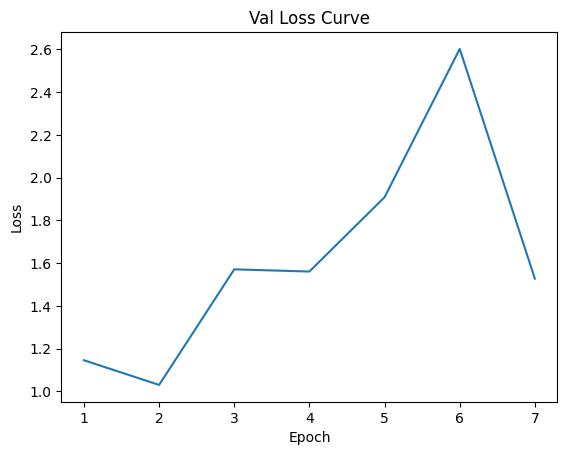

Student weights and architecture saved and exported for lambda: 10


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.3676619814599262


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.8476039342143956


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.5717068680507296


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.48420703980852575


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.48407278166097756


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.32it/s]


Average Pretrain Adversary epoch loss:  0.48424454778432846


100%|█████████████████████████████████████████| 136/136 [01:00<00:00,  2.25it/s]


Average Adversary epoch loss: 0.3431553926099749


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 1/100*****
*****Train Loss:  2.480421 Val Loss:  2.620377*****
*****Validation Accuracy: 60.58%*****
*****Total Avg Disparity: 0.12881078536642138*****

Class Team_Sports: Recall Difference = 0.037613125474397435
Class Celebration: Recall Difference = -0.10465116279069758
Class Parade: Recall Difference = 0.06040347173352123
Class Waiter_Or_Waitress: Recall Difference = -0.22836879432624113
Class Individual_Sports: Recall Difference = -0.09679723329073009
Class Surgeons: Recall Difference = -0.013186813186813251
Class Spa: Recall Difference = 0.15602836879432613
Class Law_Enforcement: Recall Difference = 0.20114942528735624
Class Business: Recall Difference = -0.03921568627450989
Class Dresses: Recall Difference = -0.6964285714285714
Class Water Activities: Recall Difference = 0.09860839312894099
Class Picnic: Recall Difference = 0.11111111111111105
Class Rescue: Recall Difference = 0.0979570455735988
Class Cheering: Recall Difference = 0.044189852700491083
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.27it/s]


Average Adversary epoch loss: 0.3141429256647825


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 2/100*****
*****Train Loss:  1.544839 Val Loss:  3.268533*****
*****Validation Accuracy: 62.66%*****
*****Total Avg Disparity: 0.1556113521748851*****

Class Team_Sports: Recall Difference = 0.022852805511765162
Class Celebration: Recall Difference = -0.09534883720930232
Class Parade: Recall Difference = 0.13007271874266946
Class Waiter_Or_Waitress: Recall Difference = -0.29645390070921973
Class Individual_Sports: Recall Difference = -0.057702428388842986
Class Surgeons: Recall Difference = -0.1296703296703296
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.2260536398467432
Class Business: Recall Difference = -0.0694799658994032
Class Dresses: Recall Difference = -0.6011904761904763
Class Water Activities: Recall Difference = 0.14187866927592951
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.16553169198533263
Class Cheering: Recall Difference = -0.11333878887070375
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.28100735223030343


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 3/100*****
*****Train Loss:  0.957986 Val Loss:  3.785853*****
*****Validation Accuracy: 63.92%*****
*****Total Avg Disparity: 0.13566230941524796*****

Class Team_Sports: Recall Difference = 0.006294155427103099
Class Celebration: Recall Difference = -0.06976744186046518
Class Parade: Recall Difference = 0.109547267182735
Class Waiter_Or_Waitress: Recall Difference = -0.3312056737588652
Class Individual_Sports: Recall Difference = -0.04364333508758744
Class Surgeons: Recall Difference = -0.1040293040293041
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.10129310344827569
Class Business: Recall Difference = -0.0421994884910486
Class Dresses: Recall Difference = -0.6428571428571428
Class Water Activities: Recall Difference = 0.06903674711893881
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.07359874279727613
Class Cheering: Recall Difference = -0.019639934533551506
Class Performance_And_Entertainment:

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.26407503101098184


 54%|██████████████████████▌                   | 73/136 [00:45<00:38,  1.66it/s]

In [ ]:
lambda_results = {}
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
    
    if i != 0:
        pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
        pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=i, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [ ]:
# Loop through each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }


In [ ]:
lambdas = list(lambda_results.keys())
teacher_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][0] for lmda in lambdas]
student_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][1] for lmda in lambdas]

plt.plot(lambdas, teacher_accuracies, label='Teacher Accuracy', marker='o')
plt.plot(lambdas, student_accuracies, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Precision
teacher_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][0] for lmda in lambdas]
student_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_precisions, label='Teacher Precision', marker='o')
plt.plot(lambdas, student_precisions, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Recall
teacher_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][0] for lmda in lambdas]
student_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_recalls, label='Teacher Recall', marker='o')
plt.plot(lambdas, student_recalls, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# F1 Score
teacher_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][0] for lmda in lambdas]
student_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_f1s, label='Teacher F1 Score', marker='o')
plt.plot(lambdas, student_f1s, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Model Size
teacher_sizes = [lambda_results[lmda]['teacher_params'] / 1e6 for lmda in lambdas]  # Convert to millions
student_sizes = [lambda_results[lmda]['student_params'] / 1e6 for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_sizes, label='Teacher Model Size', marker='o')
plt.plot(lambdas, student_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Inference Time
teacher_times = [lambda_results[lmda]['teacher_time'] for lmda in lambdas]
student_times = [lambda_results[lmda]['student_time'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_times, label='Teacher Inference Time', marker='o')
plt.plot(lambdas, student_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Extracting disparity values for both teacher and student models
student_disparities = [lambda_results[lmda]['student_mean_abs_val_disparity'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, student_disparities, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
lambda_results

In [ ]:
def plot_combined_distribution(teacher_preds, student_preds, class_names, lmda):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=teacher_preds)
    plt.title(f'Teacher Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=student_preds)
    plt.title(f'Student Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_confusion_matrix(all_labels, teacher_preds, student_preds, class_names, lmda):
    cm_teacher = confusion_matrix(all_labels, teacher_preds)
    cm_student = confusion_matrix(all_labels, student_preds)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_teacher, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Teacher Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_student, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Student Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Loop over each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Generate predictions and compute metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    all_labels = performance_metrics['all_labels']
    all_teacher_preds = performance_metrics['all_teacher_preds']
    all_student_preds = performance_metrics['all_student_preds']

    # Plot distribution and confusion matrices
    plot_combined_distribution(all_teacher_preds, all_student_preds, class_names_new, lmda)
    plot_combined_confusion_matrix(all_labels, all_teacher_preds, all_student_preds, class_names_new, lmda)

    # Print classification reports
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda})')
    print(teacher_report)
    print(f'Classification Report - Student Model (Lambda={lmda})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    # Extract bias (disparity) and accuracy values
    if model_type == 'teacher':
        bias_values = [result['teacher_mean_abs_val_disparity'][0] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][0] for result in model_results.values()]
        model_name = "Teacher"
    elif model_type == 'student':
        bias_values = [result['student_mean_abs_val_disparity'] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][1] for result in model_results.values()]
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")

    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")

# Plot for Teacher
# plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)
